In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Layer,InputSpec, concatenate, Activation,add,AveragePooling2D,BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from keras.models import Sequential
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_curve, auc, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
import matplotlib.pyplot as plt

import PIL
from PIL import Image, ImageFile
import random
import shutil
from scipy import stats
import seaborn as sns
import cv2
np.random.seed(42)

import tensorflow as tf
from tensorflow.python.platform import build_info as tf_build_info
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [8]:
#train_path = '/content/drive/MyDrive/ham10000_80_20/train_dir'
test_path = '/content/drive/MyDrive/test_dir'
batch_size = 16

In [ ]:
#  Test images preprocessing

In [9]:
datagen1=ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [10]:
datagen2=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [11]:
datagen3=ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [ ]:
image_size = 224
print("\nTest Batches: ")
test_batches1 =datagen1.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)

In [ ]:
image_size = 299

print("\nTest Batches: ")
test_batches2 =datagen2.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Test Batches: 
Found 1103 images belonging to 7 classes.


In [ ]:
image_size = 224
print("\nTest Batches: ")
test_batches3 =datagen3.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Test Batches: 
Found 1103 images belonging to 7 classes.


In [14]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()

In [15]:
#  ResNet50 -> First base model
resnet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet50.layers[-3].output

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv = Dense(512, activation='relu')(conv)
conv = Dropout(0.5)(conv)

In [17]:
output = GlobalAveragePooling2D()(conv)
output = Dense(7, activation='softmax')(output)
model1 = Model(inputs=resnet50.input, outputs=output)

In [18]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,983,895 (99.12 MB)

 Trainable params: 25,930,775 (98.92 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
#  InceptionResNetV2 -> Second base model
irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last 28 layers of the model.
conv = irv2.layers[-28].output

225209952/225209952 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [21]:
output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model2 = Model(inputs=irv2.input, outputs=output)

In [22]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 47,535,287 (181.33 MB)

 Trainable params: 47,480,887 (181.13 MB)

 Non-trainable params: 54,400 (212.50 KB)

In [23]:
#  DenseNet201 -> Third base model
densenet = tf.keras.applications.densenet.DenseNet201(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)
# Excluding the last 28 layers of the model.
conv = densenet.layers[-28].output

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

In [25]:
output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model3 = Model(inputs=densenet.input, outputs=output)

In [26]:
model3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 17,477,463 (66.67 MB)

 Trainable params: 17,264,151 (65.86 MB)

 Non-trainable params: 213,312 (833.25 KB)

In [27]:
#  Loading trained weights of ResNet50 (First base model)
model1.load_weights('/content/drive/MyDrive/ResNet50+SA_80_20_2nd.hdf5')

In [ ]:
#  Predicting confidence scores (Softmax scores) of test images by ResNet50
predictions1 = model1.predict(test_batches1)

69/69 [==============================] - 310s 5s/step


In [ ]:
print(predictions1.shape)
print(len(test_batches1.classes))

(1103, 7)
1103


In [ ]:
#  Evaluating the first base model on test images by some evaluation metrics

In [ ]:
#geting predictions on test dataset
y_pred1 = np.argmax(predictions1, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image
y_true = test_batches1.classes
#getting the predicted labels per image
y_prob=predictions1
from keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred1, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.67      0.53      0.59        30
         bcc       0.89      0.71      0.79        35
         bkl       0.74      0.60      0.66        88
          df       0.78      0.88      0.82         8
         mel       0.52      0.74      0.61        46
          nv       0.96      0.97      0.97       883
        vasc       1.00      0.85      0.92        13

    accuracy                           0.91      1103
   macro avg       0.79      0.75      0.77      1103
weighted avg       0.91      0.91      0.91      1103



In [ ]:
acc_m1 = accuracy_score(y_true, y_pred1)
print(acc_m1)

0.9102447869446962


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred1, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred1, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred1)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9132719011668208
Recall: 0.9102447869446962
Accuracy: 0.9102447869446962
weighted Roc score: 0.9773530377865163


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred1, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred1, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred1)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.792767212080122
Recall: 0.7545519264352575
Accuracy: 0.9102447869446962
Macro Roc score: 0.9793589250940687


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred1, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred1, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred1)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9102447869446962
Recall: 0.9102447869446962
Accuracy: 0.9102447869446962
Micro Roc score: 0.9927355460957465


In [ ]:
labels = {0:'akiec', 1:'bcc', 2:'bkl', 3:'df', 4:'mel', 5:'nv', 6:'vasc'}

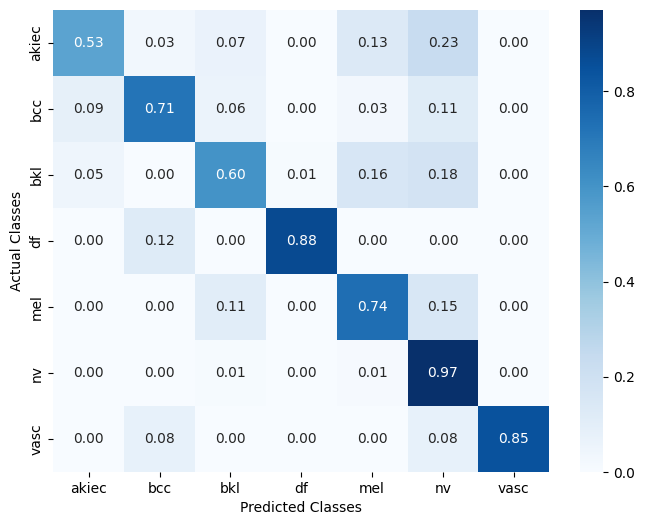

Confusion Matrix:
[[ 16   1   2   0   4   7   0]
 [  3  25   2   0   1   4   0]
 [  4   0  53   1  14  16   0]
 [  0   1   0   7   0   0   0]
 [  0   0   5   0  34   7   0]
 [  1   0  10   1  13 858   0]
 [  0   1   0   0   0   1  11]]


In [ ]:
import seaborn as sns

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
#true_labels = test_batches1.classes

# Generate predictions for the test data
#predictions = model.predict(test_generator)
#predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred1)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, xticklabels=labels.values(), yticklabels=labels.values(),cmap=plt.cm.Blues, fmt='.2f')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show(block=False)

# Generate the classification report
report = classification_report(y_true, y_pred1)

print("Confusion Matrix:")
print(cm)

In [28]:
#  Loading the trained weights of InceptionResNetV2 (Second base model)
model2.load_weights('/content/drive/MyDrive/IRV2+SA_80_20_updated.hdf5')

In [ ]:
#  Predicting the confidence scores (softmax scores) of test images by InceptionResNetV2
predictions2 = model2.predict(test_batches2)

69/69 [==============================] - 309s 4s/step


In [ ]:
#  Evaluating the second model (InceptionResNetV2) on test images by some evaluation metrics

In [ ]:
#geting predictions on test dataset
y_pred2 = np.argmax(predictions2, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image
y_true = test_batches2.classes
#getting the predicted labels per image
y_prob=predictions2
from keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred2, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.57      0.57      0.57        30
         bcc       0.89      0.49      0.63        35
         bkl       0.85      0.75      0.80        88
          df       1.00      0.38      0.55         8
         mel       0.73      0.65      0.69        46
          nv       0.95      0.99      0.97       883
        vasc       0.91      0.77      0.83        13

    accuracy                           0.92      1103
   macro avg       0.84      0.66      0.72      1103
weighted avg       0.92      0.92      0.91      1103



In [ ]:
acc_m2 = accuracy_score(y_true, y_pred2)
print(acc_m2)

0.9193109700815957


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred2, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred2, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred2)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9168785325166952
Recall: 0.9193109700815957
Accuracy: 0.9193109700815957
weighted Roc score: 0.9829494148728107


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred2, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred2, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred2)))
#print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.8420095377980079
Recall: 0.6550279429543021
Accuracy: 0.9193109700815957


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred2, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred2, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred2)))
tpr={}
fpr={}
roc_auc={}
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9193109700815957
Recall: 0.9193109700815957
Accuracy: 0.9193109700815957


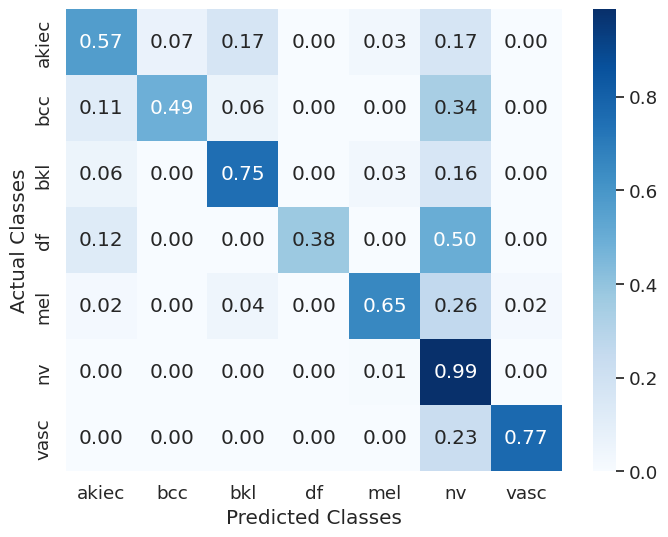

Confusion Matrix:
[[ 17   2   5   0   1   5   0]
 [  4  17   2   0   0  12   0]
 [  5   0  66   0   3  14   0]
 [  1   0   0   3   0   4   0]
 [  1   0   2   0  30  12   1]
 [  2   0   3   0   7 871   0]
 [  0   0   0   0   0   3  10]]


In [ ]:
import seaborn as sns

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
#true_labels = test_batches1.classes

# Generate predictions for the test data
#predictions = model.predict(test_generator)
#predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred2)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, xticklabels=labels.values(), yticklabels=labels.values(),cmap=plt.cm.Blues, fmt='.2f')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show(block=False)

# Generate the classification report
report = classification_report(y_true, y_pred2)

print("Confusion Matrix:")
print(cm)

In [29]:
#  Loading the trained weights of DenseNet201 (Third base model)
model3.load_weights('/content/drive/MyDrive/DenseNet201+SA_80_20.hdf5')

In [ ]:
#  Predicting the confidence scores (softmax scores) of test images by DenseNet201
predictions3 = model3.predict(test_batches3)

69/69 [==============================] - 167s 2s/step


In [ ]:
#  Evaluating the Third base model on test images by some evaluation metrics

In [ ]:
#geting predictions on test dataset
y_pred3 = np.argmax(predictions3, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image
y_true = test_batches3.classes
#getting the predicted labels per image
y_prob=predictions3
from keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred3, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.52      0.53      0.52        30
         bcc       0.89      0.71      0.79        35
         bkl       0.75      0.69      0.72        88
          df       0.88      0.88      0.88         8
         mel       0.64      0.70      0.67        46
          nv       0.97      0.98      0.97       883
        vasc       0.93      1.00      0.96        13

    accuracy                           0.92      1103
   macro avg       0.80      0.78      0.79      1103
weighted avg       0.92      0.92      0.92      1103



In [ ]:
acc_m3 = accuracy_score(y_true, y_pred3)
print(acc_m3)

0.9229374433363554


In [ ]:
print("Precision: "+ str(precision_score(y_true, y_pred3, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred3, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred3)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9227192463462071
Recall: 0.9229374433363554
Accuracy: 0.9229374433363554
weighted Roc score: 0.9848049457362469


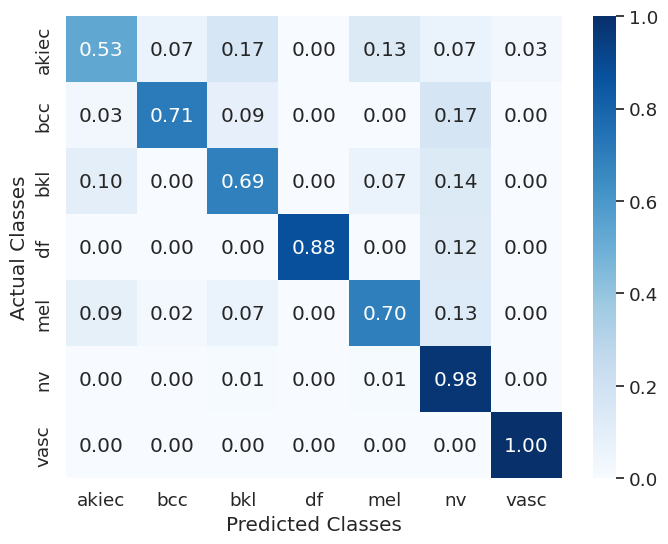

Confusion Matrix:
[[ 16   2   5   0   4   2   1]
 [  1  25   3   0   0   6   0]
 [  9   0  61   0   6  12   0]
 [  0   0   0   7   0   1   0]
 [  4   1   3   0  32   6   0]
 [  1   0   9   1   8 864   0]
 [  0   0   0   0   0   0  13]]


In [ ]:
import seaborn as sns

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
#true_labels = test_batches1.classes

# Generate predictions for the test data
#predictions = model.predict(test_generator)
#predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred3)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, xticklabels=labels.values(), yticklabels=labels.values(),cmap=plt.cm.Blues, fmt='.2f')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show(block=False)

# Generate the classification report
report = classification_report(y_true, y_pred3)

print("Confusion Matrix:")
print(cm)

In [ ]:
#  DST Combination technique for three base model

In [30]:
!pip install py_dempster_shafer

  Preparing metadata (setup.py) ... done
  Created wheel for py_dempster_shafer: filename=py_dempster_shafer-0.7-py3-none-any.whl size=13358 sha256=6028ddb27a13d383f0f8f4f1d09dfe8ffc6a508a22e0ae234cce51c9c7f19913
  Stored in directory: /root/.cache/pip/wheels/6c/16/47/07a22828af09bbeef97bcf9af8e0f51d3364253e17e06b5745
Successfully built py_dempster_shafer


In [31]:
import pyds

In [32]:
from pyds import MassFunction, powerset

In [33]:
#  Function of Demster Shafer Rule
def DempsterRule(m1, m2):
    ## extract the frame of discernment
    sets=set(m1.keys()).union(set(m2.keys()))
    result=dict.fromkeys(sets,0)
    ## Combination process
    for i in m1.keys():
        for j in m2.keys():
            if set(str(i)).intersection(set(str(j))) == set(str(i)):
                result[i]+=m1[i]*m2[j]
            elif set(str(i)).intersection(set(str(j))) == set(str(j)):
                result[j]+=m1[i]*m2[j]

    ## normalize the results
    f= sum(list(result.values()))
    for i in result.keys():
        result[i] /=f
    return result

In [34]:
def find_elements(max_key):
    str1 = str(max_key)
    subset_elements = []
    for i in labels:
        str2 = str(i)
        index = str1.find(str2)
        if index >= 0:
                subset_elements.append(i)
    return subset_elements


In [35]:
#  Function of three classifier combination
def label_prediction_from_union_3C(prediction1, prediction2, prediction3, max_key):
              sum1 = 0
              sum2 = 0
              sum3=0
              SUM =[]
              subset_elements = find_elements(max_key)
              for i in subset_elements:
                         sum1 = sum1+prediction1[i]
                         sum2 = sum2+prediction2[i]
                         sum3 = sum3+prediction3[i]
              SUM = [sum1, sum2, sum3]
              SUM = np.array(SUM)
              max_index = np.argmax(SUM)
              m_key=-1
              if max_index == 0:
                          max = 0
                          for i in subset_elements:
                                      if prediction1[i] > max:
                                        max = prediction1[i]
                                        m_key = i
                          return m_key
              elif max_index == 1:
                          max = 0
                          for i in subset_elements:
                                      if prediction2[i] > max:
                                        max = prediction2[i]
                                        m_key = i
                          return m_key
              elif max_index == 2:
                          max = 0
                          for i in subset_elements:
                                      if prediction3[i] > max:
                                        max = prediction3[i]
                                        m_key = i
                          return m_key

In [36]:
#  Function of final label prediction by DST combination
def label_prediction_3C(combined_mass, prediction1, prediction2, prediction3):
          max_keys = [key for key, value in combined_mass.items() if value == max(combined_mass.values())]
          subset_elements = find_elements(max_keys[0])
          if len(subset_elements) == 1:
                      return subset_elements[0]
          else:
                      return label_prediction_from_union_3C(prediction1, prediction2, prediction3, max_keys[0])

In [37]:
def minimum(key, prediction):
          subset_elements = find_elements(key)
          min=99
          for i in subset_elements:
                       if(prediction[i]<min):
                              min = prediction[i]
          return min

In [38]:
labels = [0, 1, 2, 3, 4, 5, 6]
pset1 = dict.fromkeys(powerset(labels), 0)

In [ ]:
#  Prediction of test images by Demster-Shafer Theory (DST) Combination
from collections import Counter
predicted_label = []
labels = [0, 1, 2, 3, 4, 5, 6]
for i in range(len(y_true)):

      pred1 = predictions1[i]
      pred2 = predictions2[i]
      pred3 = predictions3[i]

      pset1 = dict.fromkeys(powerset(labels), 0)
      pset2 = dict.fromkeys(powerset(labels), 0)
      pset3 = dict.fromkeys(powerset(labels), 0)

      for key in pset1: pset1[key] = minimum(key, pred1)
      total = float(sum(pset1.values()))
      for key in pset1: pset1[key] /= total

      for key in pset2: pset2[key] = minimum(key, pred2)
      total = float(sum(pset2.values()))
      for key in pset2: pset2[key] /= total

      for key in pset3: pset3[key] = minimum(key, pred3)
      total = float(sum(pset3.values()))
      for key in pset3: pset3[key] /= total

      Combined_mass1 = DempsterRule(pset1, pset2)
      Combined_mass = DempsterRule(Combined_mass1, pset3)
      for key in Combined_mass:
           if str(key) == "frozenset()":
                         Combined_mass[key] = 0

      predicted_label.append(label_prediction_3C(Combined_mass, predictions1[i], predictions2[i], predictions3[i]))

In [ ]:
predicted_label = np.array(predicted_label)
print(predicted_label.shape)

(1103,)


In [ ]:
y_true = test_batches1.classes
print(y_true.shape)

(1103,)


In [ ]:
#  Evaluating our proposed technique on test images by some evaluation metrics

In [ ]:
dst_accuracy = accuracy_score(y_true, predicted_label)
print(dst_accuracy)

0.9320036264732547


In [ ]:
#geting predictions on test dataset
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image
y_true = test_batches1.classes
y_prob=predicted_label
#getting the predicted labels per image
from keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, predicted_label, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.60      0.60      0.60        30
         bcc       0.95      0.60      0.74        35
         bkl       0.82      0.76      0.79        88
          df       0.83      0.62      0.71         8
         mel       0.71      0.76      0.74        46
          nv       0.96      0.99      0.97       883
        vasc       1.00      0.92      0.96        13

    accuracy                           0.93      1103
   macro avg       0.84      0.75      0.79      1103
weighted avg       0.93      0.93      0.93      1103



In [ ]:
print("Precision: "+ str(precision_score(y_true, predicted_label, average='weighted')))
print("Recall: "+ str(recall_score(y_true, predicted_label, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, predicted_label)))
#print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9315588369056736
Recall: 0.9320036264732547
Accuracy: 0.9320036264732547


In [ ]:
labels = {0:'akiec', 1:'bcc', 2:'bkl', 3:'df', 4:'mel', 5:'nv', 6:'vasc'}

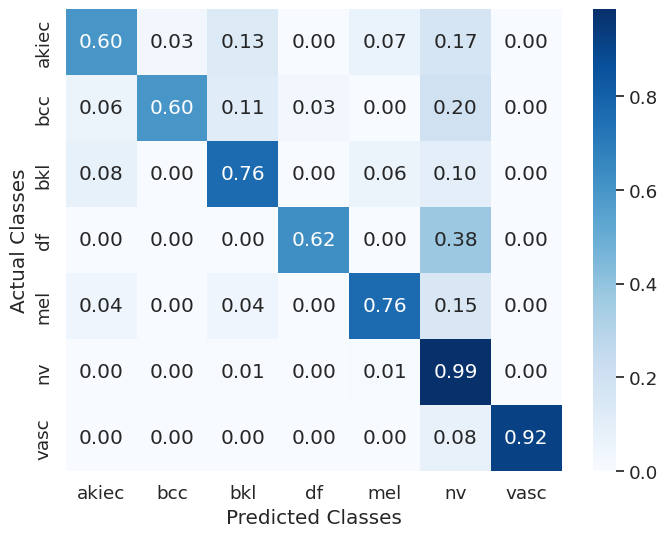

Confusion Matrix:
[[ 18   1   4   0   2   5   0]
 [  2  21   4   1   0   7   0]
 [  7   0  67   0   5   9   0]
 [  0   0   0   5   0   3   0]
 [  2   0   2   0  35   7   0]
 [  1   0   5   0   7 870   0]
 [  0   0   0   0   0   1  12]]


In [ ]:
import seaborn as sns

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
#true_labels = test_batches1.classes

# Generate predictions for the test data
#predictions = model.predict(test_generator)
#predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, predicted_label)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, xticklabels=labels.values(), yticklabels=labels.values(),cmap=plt.cm.Blues, fmt='.2f')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show(block=False)

# Generate the classification report
report = classification_report(y_true, predicted_label)

print("Confusion Matrix:")
print(cm)